In [ ]:
# Standard imports
!pip install colorama
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from colorama import Fore
from glob import glob
import json
from pprint import pprint
import time
import cv2
from enum import Enum
from IPython.display import display
from sklearn.metrics import confusion_matrix
# For Data preparation
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *


import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_df = pd.read_csv("/content/drive/MyDrive/petfinder-pawpularity-score/train.csv")
test_df = pd.read_csv( "/content/drive/MyDrive/petfinder-pawpularity-score/test.csv")
sample_df = pd.read_csv(   "/content/drive/MyDrive/petfinder-pawpularity-score/sample_submission.csv")

In [ ]:
data_df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


In [ ]:
test_df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0
5,b03f7041962238a7c9d6537e22f9b017,0,0,1,1,1,1,1,1,1,0,1,0
6,c978013571258ed6d4637f6e8cc9d6a3,1,0,0,0,1,1,0,1,0,1,1,1
7,e0de453c1bffc20c22b072b34b54e50f,1,0,1,0,0,0,0,0,1,0,0,1


In [ ]:
sample_df

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,67.75
1,43a2262d7738e3d420d453815151079e,59.15
2,4e429cead1848a298432a0acad014c9d,20.02
3,80bc3ccafcc51b66303c2c263aa38486,94.53
4,8f49844c382931444e68dffbe20228f4,89.82
5,b03f7041962238a7c9d6537e22f9b017,65.50
6,c978013571258ed6d4637f6e8cc9d6a3,71.42
7,e0de453c1bffc20c22b072b34b54e50f,5.85


In [ ]:
labels = data_df["Pawpularity"]
print(f"min value of Pawpularity is : {min(labels)}")
print(f"max value of Pawpularity is : {max(labels)}")

min value of Pawpularity is : 1
max value of Pawpularity is : 100


In [ ]:
bins = None
dark = False
fig = px.histogram(data_df, x = 'Pawpularity', template = "plotly_dark" if dark else "ggplot2", nbins = bins if bins != None else 1 + int(np.log2(len(data_df))))
fig.update_layout(
        title_text = f"Distribution of {'Pawpularity'}",
        title_x = 0.5,
)
fig.show()


In [ ]:
data_df["path"] = data_df["Id"].apply(lambda x : "/content/drive/MyDrive/petfinder-pawpularity-score/train" + f"/{x}.jpg")
test_df["path"] = test_df["Id"].apply(lambda x : "/content/drive/MyDrive/petfinder-pawpularity-score/test"+ f"/{x}.jpg")

In [ ]:
pp_100_df = data_df.loc[data_df.Pawpularity == 100]
pp_1_df = data_df.loc[data_df.Pawpularity == 1]

print(f"Num of images having 100 score : {len(pp_100_df)}")
print(f"Num of images having 1 score : {len(pp_1_df)}")

Num of images having 100 score : 288
Num of images having 1 score : 4


In [ ]:
pp_100_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
19,00768659c1c90409f81dcdecbd270513,0,1,1,0,0,0,0,0,0,0,0,0,100,/content/drive/MyDrive/petfinder-pawpularity-s...
50,013f86ed0e765b189990d3d5ac28bd7d,0,0,0,1,0,0,1,0,0,0,0,0,100,/content/drive/MyDrive/petfinder-pawpularity-s...
86,0254f54b148543442373d5aad45b2d1a,0,1,1,1,0,0,0,0,0,0,0,0,100,/content/drive/MyDrive/petfinder-pawpularity-s...
182,04fef9f129bc6e4b90644d4290fde8c3,0,1,1,1,0,0,0,0,0,0,0,0,100,/content/drive/MyDrive/petfinder-pawpularity-s...
227,063d79b149f4d163eae86f777a39a42f,0,0,1,1,0,0,0,0,0,0,0,1,100,/content/drive/MyDrive/petfinder-pawpularity-s...


In [ ]:
num_splits = 5
data=data_df
data["kfold"] = -1 
data = data.sample(frac=1).reset_index(drop=True)

# Applying Sturg's rule to calculate the no. of bins for target
num_bins = int(1 + np.log2(len(data))) 

data.loc[:, "bins"] = pd.cut(data['Pawpularity'], bins=num_bins, labels=False) 

kf = StratifiedKFold(n_splits=num_splits)

for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)): 
    data.loc[v_, 'kfold'] = f
    
data = data.drop(["bins"], axis = 1) 
data_df=data        

data_df.kfold.value_counts()

1    1983
0    1983
4    1982
3    1982
2    1982
Name: kfold, dtype: int64

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, VotingRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
!pip install catboost
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Evalution Metrix
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_validate
def rmse_score(y_label, y_preds):
    """
    Gives RMSE score
    """
    return np.sqrt(mean_squared_error(y_label, y_preds))
    

def trainRegModels(df : "data_file", features : list, label: str):
    """
    To automate the training of regression models. Considering
        > RMSE
        > R2 score
    
    """
    regModels = {
            "LinearRegression": LinearRegression(),
            "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=2),
            "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
            "DecisionTreeRegressor": DecisionTreeRegressor(),
            "RandomForestRegressor": RandomForestRegressor(n_jobs=-1),
        }
    
    # Will return this as a data frame
    summary = {
        "Model" : [],
        "Avg R2 Train Score" : [],
        "Avg R2 Val Score" : [],
        "Avg RSME Train Score" : [],
        "Avg RSME Val Score" : []
    }
    
    # Training
    for idx in trange(len(regModels.keys()), desc = "Models are training...", bar_format="{l_bar}%s{bar:50}%s{r_bar}" % (Fore.CYAN, Fore.RESET), position = 0, leave = True):
        name = list(regModels.keys())[idx]
        model = regModels[name]
        
        # Initializing all the scores to 0
        r2_train = 0; r2_val = 0
        rmse_train = 0; rmse_val = 0
        
        # Running K-fold Cross-validation on every model
        for fold in range(5):
            train_df = df.loc[df.kfold != fold].reset_index(drop = True)
            val_df = df.loc[df.kfold == fold].reset_index(drop = True)
            
            train_X = train_df[features]; train_Y = train_df[label]
            val_X = val_df[features]; val_Y = val_df[label]
            
            cur_model = model
            if name == 'CatBoostRegressor':
                cur_model.fit(train_X, train_Y,verbose=False)
            else:
                cur_model.fit(train_X, train_Y)

            Y_train_preds = model.predict(train_X)
            Y_val_preds = model.predict(val_X)
            
            # Collecting the scores
            r2_train += r2_score(train_Y, Y_train_preds)
            r2_val += r2_score(val_Y, Y_val_preds)
            
            rmse_train += rmse_score(train_Y, Y_train_preds)
            rmse_val += rmse_score(val_Y, Y_val_preds)
        
        # Pushing the scores and the Model names
        summary["Model"].append(name)
        summary["Avg R2 Train Score"].append(r2_train/5)
        summary["Avg R2 Val Score"].append(r2_val/5)
        summary["Avg RSME Train Score"].append(rmse_train/5)
        summary["Avg RSME Val Score"].append(rmse_val/5)
    
    # Finally returning the summary dictionary as a dataframe
    summary_df = pd.DataFrame(summary)
    return summary_df


In [ ]:
req_cols = [
    'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'
]
training_summary = trainRegModels(data_df, req_cols, "Pawpularity")
training_summary

Models are training...: 100%|██████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.15s/it]


,Model,Avg R2 Train Score,Avg R2 Val Score,Avg RSME Train Score,Avg RSME Val Score
0,LinearRegression,0.002714,-0.000341,20.562978,20.594344
1,KNeighborsRegressor,-0.683220,-0.716607,26.317668,26.605666
2,GradientBoostingRegressor,0.014295,-0.000680,20.443236,20.597883
3,DecisionTreeRegressor,0.033930,-0.030120,20.238597,20.898306
4,RandomForestRegressor,0.032020,-0.018811,20.258595,20.783492


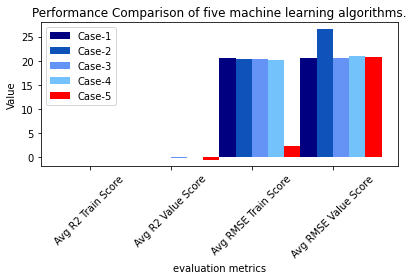

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


data = np.array([[ 0.00271445, 0.014272,  0.032205,  0.034189,  -0.0411631],
  [-0.000577, -0.001879, -0.20662, -0.033994,-0.468784],[20.56297787, 20.31766752, 20.44323644, 20.23859733, 2.25859471],
  [20.59434407, 26.60566574, 20.59788302, 20.89830608, 20.78349217]])
length = len(data)
x_labels = ['Avg R2 Train Score', 'Avg R2 Value Score', 'Avg RMSE Train Score','Avg RMSE Value Score']


# Set plot parameters
fig, ax = plt.subplots()
width = 0.2 # width of bar
x = np.arange(length)

ax.bar(x, data[:,0], width, color='#000080', label='Case-1')
ax.bar(x + width, data[:,1], width, color='#0F52BA', label='Case-2')
ax.bar(x + (2 * width), data[:,2], width, color='#6593F5', label='Case-3')
ax.bar(x + (3 * width), data[:,3], width, color='#73C2FB', label='Case-4')
ax.bar(x + (4 * width), data[:,4], width, color='r', label='Case-5')

ax.set_ylabel('Value')
ax.set_xticks(x + width + width/2)
ax.set_xticklabels(x_labels, rotation=45)
ax.set_xlabel('evaluation metrics')
ax.set_title('Performance Comparison of five machine learning algorithms.')
ax.legend()

fig.tight_layout()
plt.show()


In [ ]:

actual= training_summary['Model'].values
actual


array(['LinearRegression', 'KNeighborsRegressor',
       'GradientBoostingRegressor', 'DecisionTreeRegressor',
       'RandomForestRegressor'], dtype=object)

In [ ]:
training_summary.sort_values("Avg RSME Val Score", axis = 0, ascending = True)

,Model,Avg R2 Train Score,Avg R2 Val Score,Avg RSME Train Score,Avg RSME Val Score
0,LinearRegression,0.002738,-0.000577,20.562730,20.596679
2,GradientBoostingRegressor,0.014272,-0.001879,20.443480,20.610220
4,RandomForestRegressor,0.032205,-0.020662,20.256667,20.802399
3,DecisionTreeRegressor,0.034189,-0.033994,20.235887,20.937926
1,KNeighborsRegressor,-0.411631,-0.468784,24.435322,24.929135


In [ ]:
en = ElasticNet(random_state=0)
gbr = GradientBoostingRegressor(random_state=0)
VR_model = VotingRegressor([('en', en),('gbr', gbr)], n_jobs=-1)

r2_train = 0; r2_val = 0
rmse_train = 0; rmse_val = 0

model = VR_model
for fold in trange(5, desc = "Models are training...", bar_format="{l_bar}%s{bar:50}%s{r_bar}" % (Fore.CYAN, Fore.RESET), position = 0, leave = True):
    train_df = data_df.loc[data_df.kfold != fold].reset_index(drop = True)
    val_df = data_df.loc[data_df.kfold == fold].reset_index(drop = True)

    train_X = train_df[req_cols]; train_Y = train_df["Pawpularity"]
    val_X = val_df[req_cols]; val_Y = val_df["Pawpularity"]
    
    model.fit(train_X, train_Y)

    Y_train_preds = model.predict(train_X)
    Y_val_preds = model.predict(val_X)

    # Collecting the scores
    r2_train += r2_score(train_Y, Y_train_preds)
    r2_val += r2_score(val_Y, Y_val_preds)

    rmse_train += rmse_score(train_Y, Y_train_preds)
    rmse_val += rmse_score(val_Y, Y_val_preds)

print(f"Avg RSME Val Score : {rmse_val/5}")


Models are training...: 100%|██████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]

Avg RSME Val Score : 20.572824301999976


In [ ]:
test_X = test_df[req_cols]

model_preds = model.predict(test_X)
test_df["Pawpularity"] = model_preds

submission = test_df[["Id", "Pawpularity"]]
submission.to_csv("submission.csv", index = False)
data_df.to_csv("data.csv", index = False)
test_df.to_csv("test.csv", index = False)
submission

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,35.911807
1,43a2262d7738e3d420d453815151079e,37.221033
2,4e429cead1848a298432a0acad014c9d,48.224210
3,80bc3ccafcc51b66303c2c263aa38486,33.026713
4,8f49844c382931444e68dffbe20228f4,27.041284
5,b03f7041962238a7c9d6537e22f9b017,40.739421
6,c978013571258ed6d4637f6e8cc9d6a3,32.602862
7,e0de453c1bffc20c22b072b34b54e50f,35.663131


In [ ]:

from sklearn import metrics

actual= sample_df['Pawpularity'].values
predicted=submission['Pawpularity'].values
actual
predicted
test_df.mean()
data_df.mean()
data_df.std()
test_df.std()


Subject Focus    0.517549
Eyes             0.462910
Face             0.517549
Near             0.462910
Action           0.517549
Accessory        0.517549
Group            0.534522
Collage          0.517549
Human            0.462910
Occlusion        0.534522
Info             0.517549
Blur             0.534522
Pawpularity      6.249649
dtype: float64